In [13]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score


RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
sub = 2
num_trials_to_remove = 48

# eda data
import os
os.chdir('..')
!ls

 complete_pooled	  extract_features_signals.py  'PPCA example'
 data			  fake_signals		       'PPCA example.pdf'
 data_fake		  model			        __pycache__
 deepemogp		  old_files		        requirements.txt
 extract_correct_csv.py   output		        test


In [4]:

# hr data
hr = pd.read_csv('data_fake/features_4_2/hr/'+str(sub)+'.csv')
hr = hr[num_trials_to_remove:]

# pain expectation data
df_ = pd.read_csv('data/LookAtMe_00'+str(sub)+'.csv', sep='\t')
df_ = df_[num_trials_to_remove:]
label = np.array(list([int(d>2) for d in df_['rating']]))
E = label[:,np.newaxis]
E = pd.DataFrame(E)

# num trials
N = hr.shape[1]

TRAIN_PERC = 0.70
VAL_PERC = 0.1
TEST_PERC = 0.2  # 1-TRAIN_PERC+VAL_PERC
N_train = int(len(hr) * (TRAIN_PERC))
N_val = int(len(hr) * (VAL_PERC))

# RANDOM SPLIT
hr = hr.sample(frac=1, random_state=0)
hr = hr.reset_index(drop=True).to_numpy()

e_labels = E.sample(frac=1, random_state=0)
e_labels = e_labels.reset_index(drop=True).to_numpy()

hr_train = hr[:N_train]
e_labels_train = e_labels[:N_train]


hr_val = hr[N_train:N_train + N_val]
e_labels_val = e_labels[N_train:N_train + N_val]

hr_test = hr[N_train + N_val:]
e_test = e_labels[N_train + N_val:]

In [5]:
# dimensions of each signal
d_hr = hr_train.shape[1]
d_e = e_labels_train.shape[1]

In [6]:
d_hr

24

In [7]:
d_e

1

In [84]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="aesara"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"aesara", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "aesara":
            return at.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = at.zeros((d, k), dtype=float) if mtype == "aesara" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

In [85]:
def makeW(d, k, dim_names,name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_"+name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_"+name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, at.ones(k))
    W = pm.Deterministic(name, at.dot(L, at.diag(at.extra_ops.cumsum(z))), dims=dim_names)
    return W


In [15]:
k = 2

# start from here

In [1]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
k=2

In [3]:
# Create an empty matrix with shape (100, 20)
hr_train = np.empty((80, 20))

# Generate indices of rows that should have values greater than 100
high_value_rows = np.random.choice(np.arange(80), size=40, replace=False)

# Fill the rows with high values
hr_train[high_value_rows] = np.random.randint(101, high=1000, size=(40, 20))

# Fill the remaining rows with values less than or equal to 90
hr_train[np.setdiff1d(np.arange(80), high_value_rows)] = np.random.randint(0, high=91, size=(40, 20))

In [4]:
# Create an empty matrix with shape (100, 20)
label_train = np.empty((80, 1))

# Fill the rows with high values
label_train[high_value_rows] = np.ones(shape=(40,1), dtype=int)

# Fill the remaining rows with values less than or equal to 90
label_train[np.setdiff1d(np.arange(80), high_value_rows)] = np.zeros(shape=(40,1), dtype=int)

In [5]:
print(hr_train.shape)
print(label_train.shape)

(80, 20)
(80, 1)


In [6]:
# Create an empty matrix with shape (100, 20)
hr_val = np.empty((20, 20))

# Generate indices of rows that should have values greater than 100
high_value_rows = np.random.choice(np.arange(20), size=10, replace=False)

# Fill the rows with high values
hr_val[high_value_rows] = np.random.randint(101, high=1000, size=(10, 20))

# Fill the remaining rows with values less than or equal to 90
hr_val[np.setdiff1d(np.arange(20), high_value_rows)] = np.random.randint(0, high=91, size=(10, 20))

In [7]:
# Create an empty matrix with shape (100, 20)
e_labels_val = np.empty((20, 1))

# Fill the rows with high values
e_labels_val[high_value_rows] = np.ones(shape=(10,1), dtype=int)

# Fill the remaining rows with values less than or equal to 90
e_labels_val[np.setdiff1d(np.arange(20), high_value_rows)] = np.zeros(shape=(10,1), dtype=int)

In [8]:
print(hr_val.shape)
print(e_labels_val.shape)

(20, 20)
(20, 1)


In [9]:
d_hr = hr_train.shape[1]
d_e = label_train.shape[1]
N_train=hr_train.shape[0]
e_labels_train = label_train

In [10]:
with pm.Model() as PPCA_identified:
    #model coordinates
    PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
    PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
    PPCA_identified.add_coord("observed_hr", np.arange(d_hr), mutable=False)
    PPCA_identified.add_coord("observed_label", np.arange(d_e), mutable=False)


    hr_data = pm.MutableData("hr_data", hr_train.T, dims=("observed_hr", "rows"))
    e = pm.ConstantData("e",e_labels_train.T,dims=('observed_label','rows'))

    W_hr = pm.Normal('Whr', mu=0, sigma=2.0 * 1, dims= ["observed_hr", "latent_columns"])
    W_e = pm.Normal("W_e",  mu=0, sigma=2.0 * 1, dims=("observed_label", "latent_columns"))

    C = pm.Normal("C", dims=("latent_columns", "rows"))

    X_hr = pm.Normal("X_hr", mu=at.dot(W_hr, C), sigma=2, observed=hr_data, dims=("observed_hr", "rows"))

    X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(at.dot(W_e, C)), dims=("observed_label", "rows"), observed=e)

In [11]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA example')

'PPCA example.pdf'

In [12]:
with PPCA_identified:
    print(W_hr)

Whr


In [13]:
with PPCA_identified:
    approx = pm.fit(100000)
    trace = approx.sample(10000)

qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Finished [100%]: Average Loss = 5.9195e+06


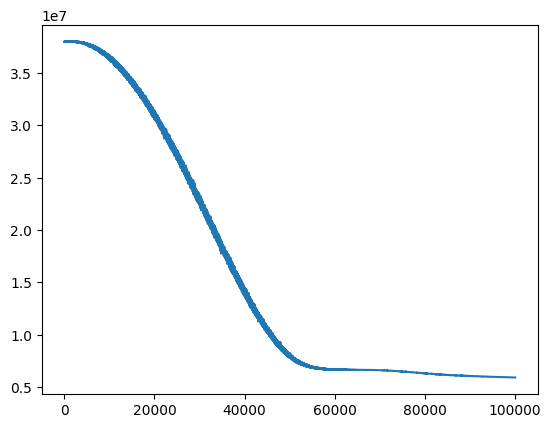

In [14]:
plt.plot(approx.hist)

array([[<AxesSubplot: title={'center': 'Whr'}>,
        <AxesSubplot: title={'center': 'Whr'}>],
       [<AxesSubplot: title={'center': 'W_e'}>,
        <AxesSubplot: title={'center': 'W_e'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'C'}>]], dtype=object)

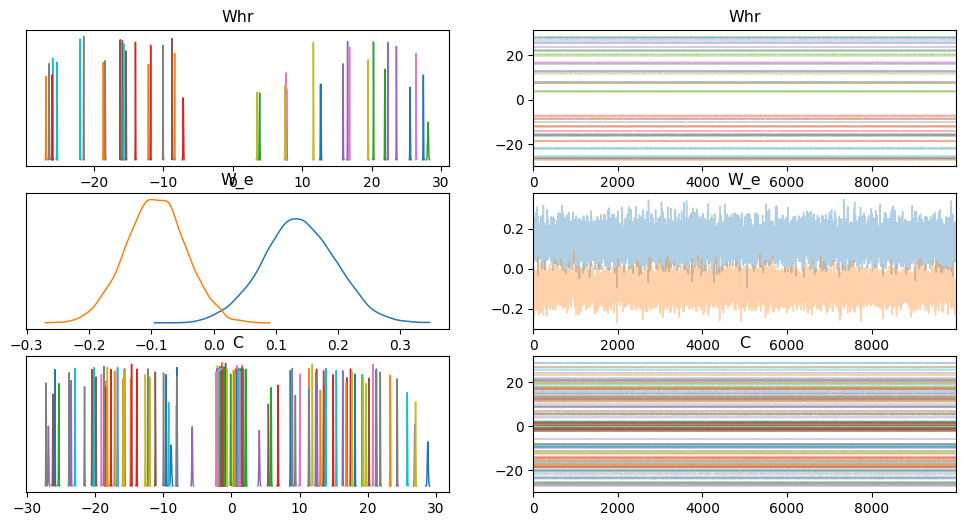

In [15]:
az.plot_trace(trace)

In [16]:
trace.observed_data['X_hr']

<xarray.DataArray 'X_hr' (observed_hr: 20, rows: 80)>
array([[823., 458.,  45., ..., 859., 669., 901.],
       [335., 611.,  11., ..., 657., 353., 446.],
       [183., 130.,   1., ..., 946., 239., 978.],
       ...,
       [892., 373.,  33., ..., 656., 781., 109.],
       [312., 943.,  80., ..., 802., 743., 259.],
       [542., 976.,  63., ..., 221., 601., 861.]])
Coordinates:
  * observed_hr  (observed_hr) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * rows         (rows) int64 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79

In [17]:
c_

NameError: name 'c_' is not defined

In [ ]:
#C = np.random.randint(low=0, high=10, size=(3, 1))
#W = np.random.randint(low=0, high=10, size=(3, 5))

In [ ]:
c_ = trace.posterior['C'][0].to_numpy().mean(axis=0)
whr_ = trace.posterior['Whr'][0].to_numpy().mean(axis=0)
we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)

O = np.dot(we_,c_)
generated= np.matmul(np.linalg.pinv(we_), O)
np.allclose(c_,generated)

True

In [42]:
with PPCA_identified:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123, predictions=True)

Sampling: [X_e]


In [43]:
we_postpp = np.squeeze(W_e.eval())
whr_postpp = np.squeeze(W_hr.eval())
c_postpp=np.squeeze(C.eval())

In [44]:
xe_postpp = np.squeeze(X_e.eval())
xhr_postpp = np.squeeze(X_hr.eval())
c_postpp=np.squeeze(C.eval())

In [45]:
print(np.count_nonzero(xe_posttrain-xe_postpp))
print(np.count_nonzero(xhr_posttrain-xhr_postpp))
print(np.count_nonzero(c_posttrain-c_postpp))

28
0
0


In [49]:
posterior_predictive.predictions['X_e']

<xarray.DataArray 'X_e' (chain: 1, draw: 10000, observed_label: 1, rows: 80)>
array([[[[1, 0, 1, ..., 1, 1, 1]],

        [[0, 1, 1, ..., 1, 1, 1]],

        [[0, 0, 1, ..., 1, 1, 0]],

        ...,

        [[0, 1, 1, ..., 0, 1, 1]],

        [[0, 0, 1, ..., 1, 1, 0]],

        [[0, 0, 1, ..., 1, 1, 1]]]])
Coordinates:
  * chain           (chain) int64 0
  * draw            (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * observed_label  (observed_label) int64 0
  * rows            (rows) int64 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79

In [46]:
e_pred = posterior_predictive.predictions['X_e']
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:, np.newaxis]

In [47]:
train_accuracy_exp = accuracy_score(e_labels_train,e_pred_mode)
train_accuracy_exp

0.5

In [48]:
# update values of predictors with validation:
PPCA_identified.set_data(name='hr_data',values =hr_val.T,coords={'rows': range(hr_val.shape[0])})
#PPCA_identified.add_coord()

In [ ]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA example')

In [ ]:
with PPCA_identified:

    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123, predictions=True)

In [33]:
e_pred = posterior_predictive.predictions_constant_data['X_e']
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:, np.newaxis]

validation_accuracy_exp = accuracy_score(e_labels_val, e_pred_mode)

AttributeError: 'InferenceData' object has no attribute 'predictions_constant_data'

In [23]:
validation_accuracy_exp

0.36363636363636365